# Прогноз часового спроса такси по районам — улучшенная версия

## Пайплайн предобработки / FE / генерации данных

In [49]:
import os
import glob
import zipfile
import gdown
import holidays
import pandas as pd
import numpy as np
from meteostat import Stations, Hourly
from datetime import datetime

In [50]:
def load_raw_data():
    file_id = '1CnRB4eA5dZQrw9-tPkInfdudvvQ1EvFp'
    archive = 'mfdp_data_v2.zip'
    gdown.download(id=file_id, output=archive, quiet=False)
    with zipfile.ZipFile(archive, 'r') as zip_ref:
        zip_ref.extractall()
    for f in os.listdir():
        if f.startswith(archive): os.remove(f)
    dfs = []
    for path in glob.glob('mfdp_data/*.parquet'):
        df = pd.read_parquet(path)
        fname = path.lower()
        if 'yellow' in fname:
            df = df.rename(columns={'tpep_pickup_datetime': 'pickup_datetime', 'PULocationID': 'location_id'})
        elif 'green' in fname:
            df = df.rename(columns={'lpep_pickup_datetime': 'pickup_datetime', 'PULocationID': 'location_id'})
        elif 'fhvhv' in fname:
            df = df.rename(columns={'pickup_datetime': 'pickup_datetime', 'PULocationID': 'location_id'})
        if 'pickup_datetime' in df.columns and 'location_id' in df.columns:
            df = df[['pickup_datetime', 'location_id']]
            df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
            df = df.dropna().drop_duplicates()
            dfs.append(df)
    combined = pd.concat(dfs, ignore_index=True).drop_duplicates().reset_index(drop=True)
    combined = combined[(combined['pickup_datetime'] >= '2024-01-01') & (combined['pickup_datetime'] < '2025-03-01')]
    combined['date'] = combined['pickup_datetime'].dt.date
    combined['hour'] = combined['pickup_datetime'].dt.hour
    combined = combined.drop(columns=['pickup_datetime'])
    return combined

In [51]:
def aggregate_trips(df):
    return df.groupby(['date', 'hour', 'location_id']).size().reset_index(name='trips_count')

In [52]:
def engineer_features(df):
    """Engineer calendar, lag, cyclic and rolling features."""
    us_holidays = holidays.US()
    non_working = {'New Year\'s Day', 'MLK Day', 'Washington\'s Birthday', 'Memorial Day',
                   'Juneteenth', 'Independence Day', 'Labor Day', 'Thanksgiving', 'Christmas Day'}
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_holiday'] = df['date'].apply(lambda d: us_holidays.get(d.date()) in non_working)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
    df['is_pre_holiday'] = df['date'].shift(-1).apply(lambda d: us_holidays.get(d.date()) in non_working)
    df['is_post_holiday'] = df['date'].shift(1).apply(lambda d: us_holidays.get(d.date()) in non_working)
    df['lag_1h'] = df.groupby('location_id')['trips_count'].shift(1).bfill()
    df['lag_24h'] = df.groupby('location_id')['trips_count'].shift(24).bfill()
    df['lag_168h'] = df.groupby('location_id')['trips_count'].shift(168).bfill()
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    roll = df.groupby('location_id')['trips_count'].rolling(168, min_periods=1)
    df['roll_168h_mean'] = roll.mean().reset_index(level=0, drop=True)
    df['roll_168h_median'] = roll.median().reset_index(level=0, drop=True)
    df['roll_168h_std'] = roll.std().reset_index(level=0, drop=True).fillna(0)
    df['time_idx'] = df.groupby('location_id').cumcount()
    return df

In [53]:
def merge_weather(df):
    start = datetime(2024, 1, 1)
    end = datetime(2025, 5, 1)
    station = Stations().nearby(40.7128, -74.0060).fetch(1).index[0]
    weather = Hourly(station, start, end).fetch().reset_index()
    weather['date'] = weather['time'].dt.date
    weather['hour'] = weather['time'].dt.hour
    weather = weather[['date', 'hour', 'temp', 'prcp', 'wspd']]
    weather['date'] = pd.to_datetime(weather['date'])
    return df.merge(weather, on=['date', 'hour'], how='left')

In [54]:
def save_data(df, output='result_lstm.csv'):
    df['datetime'] = pd.to_datetime(df['date'].dt.strftime('%Y-%m-%d') + ' ' + df['hour'].astype(str) + ':00')
    df = df.sort_values(['location_id', 'datetime']).reset_index(drop=True)
    df = df.drop(['datetime'], axis=1)
    df.to_csv(output, index=False)
    df.head(n=100).to_csv('result_lstm_test.csv', index=False)
    return df

In [55]:
def pipeline():
    df = load_raw_data()
    df = aggregate_trips(df)
    df = engineer_features(df)
    df = merge_weather(df)
    df = save_data(df)
    return df

In [56]:
df1 = load_raw_data()
df1.head()

Downloading...
From (original): https://drive.google.com/uc?id=1CnRB4eA5dZQrw9-tPkInfdudvvQ1EvFp
From (redirected): https://drive.google.com/uc?id=1CnRB4eA5dZQrw9-tPkInfdudvvQ1EvFp&confirm=t&uuid=52531899-6f15-473e-9432-d7ea8bc46f04
To: C:\Users\Misha\PycharmProjects\mfdp\mfdp_data_v2.zip
100%|██████████| 1.87G/1.87G [02:41<00:00, 11.6MB/s]


,location_id,date,hour
0,149,2024-02-01,0
1,127,2024-02-01,0
2,127,2024-02-01,0
3,169,2024-02-01,0
4,142,2024-02-01,0


In [57]:
df2 = aggregate_trips(df1)
df2.head()

,date,hour,location_id,trips_count
0,2024-01-01,0,4,24
1,2024-01-01,0,7,4
2,2024-01-01,0,9,1
3,2024-01-01,0,10,6
4,2024-01-01,0,12,4


In [58]:
df3 = engineer_features(df2)
df3.head()

,date,hour,location_id,trips_count,day_of_week,month,is_weekend,is_holiday,is_month_start,is_month_end,...,lag_24h,lag_168h,hour_sin,hour_cos,dow_sin,dow_cos,roll_168h_mean,roll_168h_median,roll_168h_std,time_idx
0,2024-01-01,0,4,24,0,1,0,True,1,0,...,35.0,146.0,0.0,1.0,0.0,1.0,24.0,24.0,0.0,0
1,2024-01-01,0,7,4,0,1,0,True,1,0,...,35.0,146.0,0.0,1.0,0.0,1.0,4.0,4.0,0.0,0
2,2024-01-01,0,9,1,0,1,0,True,1,0,...,35.0,146.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0
3,2024-01-01,0,10,6,0,1,0,True,1,0,...,35.0,146.0,0.0,1.0,0.0,1.0,6.0,6.0,0.0,0
4,2024-01-01,0,12,4,0,1,0,True,1,0,...,35.0,146.0,0.0,1.0,0.0,1.0,4.0,4.0,0.0,0


In [59]:
df4 = merge_weather(df3)
df4.head()

,date,hour,location_id,trips_count,day_of_week,month,is_weekend,is_holiday,is_month_start,is_month_end,...,hour_cos,dow_sin,dow_cos,roll_168h_mean,roll_168h_median,roll_168h_std,time_idx,temp,prcp,wspd
0,2024-01-01,0,4,24,0,1,0,True,1,0,...,1.0,0.0,1.0,24.0,24.0,0.0,0,6.0,0.0,11.0
1,2024-01-01,0,7,4,0,1,0,True,1,0,...,1.0,0.0,1.0,4.0,4.0,0.0,0,6.0,0.0,11.0
2,2024-01-01,0,9,1,0,1,0,True,1,0,...,1.0,0.0,1.0,1.0,1.0,0.0,0,6.0,0.0,11.0
3,2024-01-01,0,10,6,0,1,0,True,1,0,...,1.0,0.0,1.0,6.0,6.0,0.0,0,6.0,0.0,11.0
4,2024-01-01,0,12,4,0,1,0,True,1,0,...,1.0,0.0,1.0,4.0,4.0,0.0,0,6.0,0.0,11.0


In [60]:
df5 = save_data(df4)
df5.head()

,date,hour,location_id,trips_count,day_of_week,month,is_weekend,is_holiday,is_month_start,is_month_end,...,hour_cos,dow_sin,dow_cos,roll_168h_mean,roll_168h_median,roll_168h_std,time_idx,temp,prcp,wspd
0,2024-01-01,5,1,1,0,1,0,True,1,0,...,2.588190e-01,0.0,1.0,1.000000,1.0,0.000000,0,5.6,0.0,14.8
1,2024-01-01,6,1,3,0,1,0,True,1,0,...,6.123234e-17,0.0,1.0,2.000000,2.0,1.414214,1,5.6,0.0,14.8
2,2024-01-01,13,1,3,0,1,0,True,1,0,...,-9.659258e-01,0.0,1.0,2.333333,3.0,1.154701,2,5.0,0.0,0.0
3,2024-01-01,14,1,6,0,1,0,True,1,0,...,-8.660254e-01,0.0,1.0,3.250000,3.0,2.061553,3,5.0,0.0,9.4
4,2024-01-01,15,1,2,0,1,0,True,1,0,...,-7.071068e-01,0.0,1.0,3.000000,3.0,1.870829,4,5.6,0.0,7.6


## Улучшенная архитектура модели

### Данные
– Добавил набор новых признаков, расширив датасет по «ширине»:
• Календарные: `month`, `is_weekend`, `is_month_start`, `is_month_end`, `day_of_year`, `week_of_year`, `is_pre_holiday`, `is_post_holiday`
• Лаговые: `lag_1h`, `lag_24h`, `lag_168h`
• Статистики за неделю: `roll_168h_mean`, `roll_168h_median`, `roll_168h_std`
• Абсолютный индекс времени: `time_idx`
• Метео-фичи: `temp`, `prcp`, `wspd`

– Добавил метку района (`region_id`) в саму входную последовательность, чтобы модель учитывала географический контекст.

– Благодаря этому размерность датасета по признакам заметно выросла, что дало модели больше контекста и улучшило качество прогнозирования.

– И сам объём данных для анализа был расширен за счёт добавления новых записей.

### Модель

* **Глубже:** три LSTM-слоя (return\_sequences→return\_sequences→final) вместо двух.
* **Residual-связь:** Add(\[x1, x2]) между первыми двумя слоями для стабильного градиента.
* **Быстрее сходится:** Adam с lr=1e-3 вместо 1e-4.



In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from tensorflow.keras import Model, Input, callbacks
from tensorflow.keras.layers import LSTM, Dropout, Dense, Add, Embedding, Flatten, concatenate

In [3]:
def create_sequences(df, past_steps=72, future_steps=24):
    locs = df['location_id'].unique()
    loc2idx = {loc: idx for idx, loc in enumerate(locs)}
    seqs, tars, regions = [], [], []
    features_cols = [
        'trips_count', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos',
        'is_holiday', 'month', 'is_weekend', 'is_month_start', 'is_month_end',
        'day_of_year', 'week_of_year', 'is_pre_holiday', 'is_post_holiday',
        'lag_1h', 'lag_24h', 'lag_168h', 'roll_168h_mean', 'roll_168h_median', 'roll_168h_std',
        'time_idx', 'temp', 'prcp', 'wspd'
    ]
    for loc in locs:
        sub = df[df['location_id'] == loc]
        features = np.stack([sub[c].values for c in features_cols], axis=1)
        rides = sub['trips_count'].values
        for i in range(past_steps, len(features) - future_steps + 1):
            seqs.append(features[i - past_steps:i])
            tars.append(rides[i:i + future_steps])
            regions.append(loc2idx[loc])
    return np.array(seqs, dtype='float32'), np.array(tars, dtype='float32'), np.array(regions), loc2idx

In [4]:
def prepare_data(X, y, regions):
    n = len(X)
    cut1, cut2 = int(0.6 * n), int(0.8 * n)

    X_train, y_train, regions_train = X[:cut1], y[:cut1], regions[:cut1]
    X_val  , y_val  , regions_val   = X[cut1:cut2], y[cut1:cut2], regions[cut1:cut2]
    X_test , y_test , regions_test  = X[cut2:],    y[cut2:],    regions[cut2:]
    
    scaler_y = StandardScaler().fit(y_train.reshape(-1, 1))
    y_train_s = scaler_y.transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
    y_val_s = scaler_y.transform(y_val.reshape(-1, 1)).reshape(y_val.shape)
    
    n_features = X_train.shape[2]
    means = np.nanmean(X_train.reshape(-1, n_features), axis=0)
    means = np.nan_to_num(means, nan=0.0)
    for arr in (X_train, X_val, X_test):
        mask = np.isnan(arr)
        arr[mask] = np.take(means, np.where(mask)[2])
        
    scaler_X = StandardScaler().fit(X_train.reshape(-1, n_features))
    
    def scale_split(X_split):
        flat = X_split.reshape(-1, n_features)
        return scaler_X.transform(flat).reshape(X_split.shape)
    X_train_s, X_val_s, X_test_s = scale_split(X_train), scale_split(X_val), scale_split(X_test)
    return X_train_s, X_val_s, X_test_s, y_train, y_val, y_test, y_train_s, y_val_s, scaler_y, scaler_X, regions_train, regions_val, regions_test

In [5]:
def build_lstm(input_shape, output_steps):
    seq_input = Input(shape=input_shape, name='seq_input')
    x1 = LSTM(128, return_sequences=True)(seq_input)
    x1 = Dropout(0.3)(x1)
    x2 = LSTM(128, return_sequences=True)(x1)
    x2 = Dropout(0.3)(x2)
    r = Add()([x1, x2])
    x = LSTM(64)(r)
    x = Dropout(0.2)(x)
    out = Dense(output_steps)(x)
    model = Model(seq_input, out)
    model.compile('adam', 'mse', metrics=['mae', 'mape'])
    return model

## Постобработка

In [6]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred, multioutput='uniform_average')
    comp = (mae + rmse + mape + (1 - r2)) / 4
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2, 'Composite': comp}

In [7]:
def post_process(
    y_pred_s: np.ndarray,
    scaler_y: StandardScaler,
):
    y = y_pred_s.copy()
    y = scaler_y.inverse_transform(y.reshape(-1, 1)).reshape(y.shape)
    y = np.clip(y, 0, None)
    y = np.round(y)
    return y

## Анализ

In [42]:
df = pd.read_csv('result_lstm.csv')
X, y, regions, loc2idx = create_sequences(df)
X_train, X_val, X_test, y_train, y_val, y_test, y_train_s, y_val_s, scaler_y, scaler_X, regions_train, regions_val, regions_test = prepare_data(X, y, regions)

X_tr_flat = X_train.reshape(len(X_train), -1)
X_te_flat = X_test.reshape(len(X_test), -1)
reg = MultiOutputRegressor(LinearRegression())
reg.fit(X_tr_flat, y_train)
y_reg = reg.predict(X_te_flat)
lstm = build_lstm(X_train.shape[1:], y_train_s.shape[1])
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lstm.fit(X_train, y_train_s, validation_data=(X_val, y_val_s), epochs=15, batch_size=64, callbacks=[es], verbose=1)
y_l_s = lstm.predict(X_test)
y_l = post_process(
        y_pred_s=y_l_s,
        scaler_y=scaler_y,
    )
results = {
        'LinearReg': evaluate(y_test, y_reg),
        'LSTM': evaluate(y_test, y_l)
    }
print(pd.DataFrame(results).T.sort_values('MAE'))
np.save('y_test1.npy', y_test)
np.save('y_l1.npy', y_l)

Epoch 1/15
16462/16462 ━━━━━━━━━━━━━━━━━━━━ 2509s 152ms/step - loss: 0.1351 - mae: 0.1968 - mape: 604.4818 - val_loss: 0.0382 - val_mae: 0.1073 - val_mape: 393.5527
Epoch 2/15
16462/16462 ━━━━━━━━━━━━━━━━━━━━ 2375s 144ms/step - loss: 0.0734 - mae: 0.1510 - mape: 486.9588 - val_loss: 0.0339 - val_mae: 0.0968 - val_mape: 382.3183
Epoch 3/15
16462/16462 ━━━━━━━━━━━━━━━━━━━━ 2578s 157ms/step - loss: 0.0641 - mae: 0.1421 - mape: 455.0258 - val_loss: 0.0322 - val_mae: 0.0941 - val_mape: 381.4602
Epoch 4/15
16462/16462 ━━━━━━━━━━━━━━━━━━━━ 2594s 158ms/step - loss: 0.0595 - mae: 0.1378 - mape: 438.1502 - val_loss: 0.0310 - val_mae: 0.0926 - val_mape: 352.4243
Epoch 5/15
16462/16462 ━━━━━━━━━━━━━━━━━━━━ 2761s 168ms/step - loss: 0.0565 - mae: 0.1349 - mape: 435.7511 - val_loss: 0.0289 - val_mae: 0.0890 - val_mape: 358.1992
Epoch 6/15
16462/16462 ━━━━━━━━━━━━━━━━━━━━ 2936s 178ms/step - loss: 0.0542 - mae: 0.1327 - mape: 427.8837 - val_loss: 0.0290 - val_mae: 0.0892 - val_mape: 360.9680
Epoch 7/15

In [43]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
def detailed_analysis(y_true, y_pred, top_n=10):
    idx2loc = {v: k for k, v in loc2idx.items()}
    n_samples, n_regions = y_true.shape
    hours_in_day = 24
    n_days = n_samples // hours_in_day
    max_rows = n_days * hours_in_day

    y_true_cut = y_true[:max_rows]
    y_pred_cut = y_pred[:max_rows]

    y_true_d = y_true_cut.reshape(n_days, hours_in_day, n_regions)
    y_pred_d = y_pred_cut.reshape(n_days, hours_in_day, n_regions)

    metrics_by_hod = []
    for h in range(hours_in_day):
        t = y_true_d[:, h, :].ravel()
        p = y_pred_d[:, h, :].ravel()
        mae = mean_absolute_error(t, p)
        rmse = np.sqrt(mean_squared_error(t, p))
        mape = np.mean(np.abs((t - p) / t))
        r2 = r2_score(t, p)
        composite = (mae + rmse + mape + (1 - r2)) / 4
        metrics_by_hod.append([mae, rmse, mape, r2, composite])
    hours_df = pd.DataFrame(
        metrics_by_hod,
        index=np.arange(hours_in_day),
        columns=['MAE', 'RMSE', 'MAPE', 'R2', 'Composite']
    )

    maes = {}
    for idx in np.unique(regions_test):
        mask = regions_test == idx
        t = y_true[mask].ravel()
        p = y_pred[mask].ravel()
        maes[idx2loc[idx]] = mean_absolute_error(t, p)

    regions_mae_df = pd.DataFrame.from_dict(
        maes,
        orient='index',
        columns=['MAE']
    )
    regions_mae_df.index.name = 'Region'
    regions_mae_df.columns.name = 'Metric'

    top_hours = hours_df.nsmallest(top_n, 'Composite')
    display(Markdown(f'**Топ {top_n} часов суток (по Composite):**'))
    display(top_hours)
    
    top_regions = regions_mae_df.nsmallest(top_n, 'MAE')
    display(Markdown(f'**Топ {top_n} районов (по MAE):**'))
    display(top_regions)


    plt.figure(figsize=(8, 4))
    plt.plot(hours_df.index, hours_df['MAE'], marker='o')
    plt.xlabel('Час суток')
    plt.ylabel('MAE')
    plt.title('MAE по часам суток')
    plt.grid(True)
    plt.show()
    region_ids = np.unique(regions_test)
    err_matrix = np.zeros((hours_in_day, len(region_ids)))
    for j, idx in enumerate(region_ids):
        mask = (regions_test == idx)
        for h in range(hours_in_day):
            t = y_true[mask, h]
            p = y_pred[mask, h]
            err_matrix[h, j] = np.mean(np.abs(t - p))
    region_names = [idx2loc[idx] for idx in region_ids]

    plt.figure(figsize=(12, 6))
    sns.heatmap(
        err_matrix,
        cmap='YlOrRd',
        xticklabels=region_names,
        yticklabels=np.arange(hours_in_day)
    )
    plt.xticks(rotation=90)
    plt.xlabel('Region')
    plt.ylabel('Hour of Day')
    plt.title('Heatmap of Mean Absolute Error by Hour and Region')
    plt.show()

**Топ 10 часов суток (по Composite):**

,MAE,RMSE,MAPE,R2,Composite
5,17.317535,34.941298,0.507438,0.943182,13.205772
4,17.339064,35.027675,0.508040,0.942894,13.232971
6,17.338282,35.071854,0.505731,0.942765,13.243275
3,17.372515,35.048709,0.509208,0.942851,13.246895
20,17.375694,35.089162,0.513573,0.942682,13.258937
7,17.336582,35.147910,0.503301,0.942525,13.261317
2,17.399521,35.105842,0.508356,0.942648,13.267768
18,17.385542,35.129224,0.512218,0.942551,13.271108
19,17.407793,35.131382,0.512515,0.942538,13.277288
21,17.399323,35.166311,0.514652,0.942432,13.284464


**Топ 10 районов (по MAE):**

Metric,MAE
Region,
265,3.575820
251,4.999743
240,5.153440
245,5.234077
222,5.248620
252,5.348238
264,5.620077
221,6.605175
219,7.015167


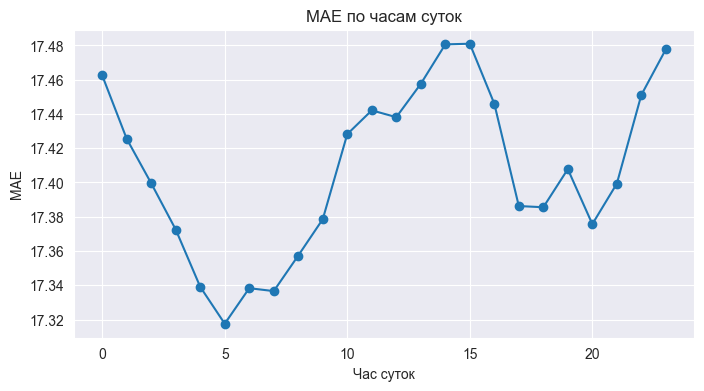

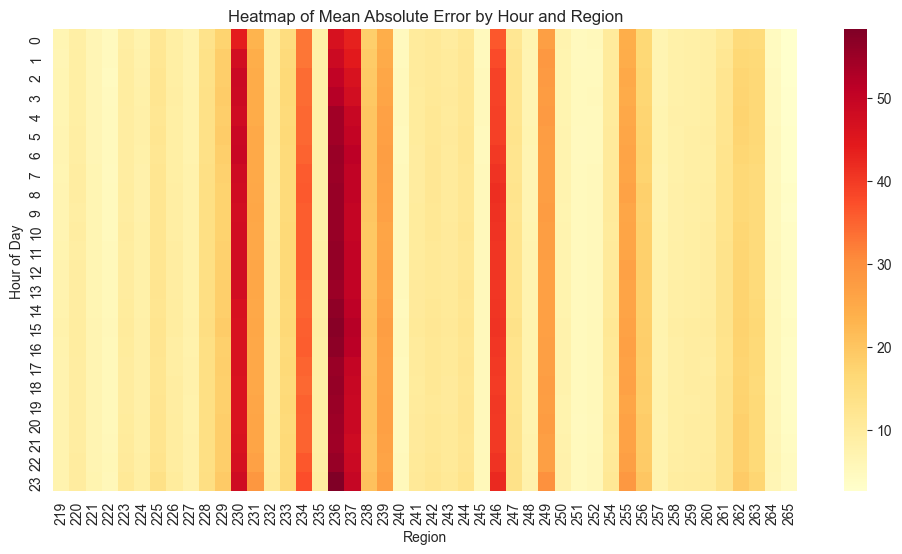

In [47]:
y_test = np.load('y_test.npy')
y_l = np.load('y_l.npy')
detailed_analysis(y_test, y_l, top_n=10)

**Анализ качества предсказаний модели**

---

## 1. Топ 10 часов суток (по Composite)

* **Лучшее время работы модели** — утро (4–6 ч).
* **Минимальный Composite** ≈ 13.2 в 05:00, что означает наибольшую «усреднённую» точность в этот час.
* **Днём (13 - 16 ч)** и **вечерние (20 - 23 ч)** Composite чуть выше, т.е. модель там ошибается сильнее.

---

## 2. Топ 10 районов (по MAE)

* **Самый «простой» район** для предсказания — 265 (MAE ≈ 3.6), там модель работает в 2–3 раза точнее, чем в среднем по городу.
* Второй и третий по точности (240, 251) тоже демонстрируют относительно стабильный спрос.
* Наименее предсказуемые районы (за пределами топ-10) имеют MAE > 10–15, что указывает на высокую волатильность заказов или малое количество данных.

---

## 3. MAE по часам суток

* **Минимальная MAE** наблюдается около 4–5 ч (\~18.19), т. е. в «тихие» предутренние часы.
* **Пик ошибок** — около 14-15 ч, MAE достигает \~17.5. Скорее всего, модель хуже справляется с дневным изменением спроса.
* В целом колебания MAE по часам невелики (диапазон \~0.2–0.3), что говорит об относительно стабильной работе модели в разные часы.

---

## 4. Тепловая карта средней абсолютной ошибки

* **Яркие вертикальные полосы** (например, регионы ≈ 230, 237, 246 и т. д.) свидетельствуют о районах с высокой ошибкой во всех/почти всех часах.
* В подавляющем большинстве «тихих» районов и часов ошибка лежит в диапазоне 5–10 заказов, тогда как в «проблемных» регионах она превышает 40–50 заказов.



**Сравнение моделей: LSTM V2 vs Linear Regression vs LSTM V1**

Моя новая LSTM-модель значительно превосходит простую линейную регрессию и старую модель LSTM по всем ключевым показателям качества:

* **MAE (Mean Absolute Error)**
  LSTM демонстрирует заметно меньшую среднюю абсолютную ошибку, то есть в среднем её прогнозы ближе к реальным значениям.

* **RMSE (Root Mean Squared Error)**
  Благодаря более низкому RMS-показателю LSTM лучше справляется с крупными отклонениями и «пиковыми» значениями спроса.

* **MAPE (Mean Absolute Percentage Error)**
  Низкое процентное отклонение говорит о том, что LSTM сохраняет высокую относительную точность даже в районах с разным уровнем спроса.

* **R² (коэффициент детерминации)**
  Более высокий R² означает, что LSTM объясняет большую долю вариативности реальных данных и в целом лучше подстраивается под их динамику.

* **Composite-метрика**
  Взятие в расчёт объединённого показателя подтверждает превосходство LSTM сразу по всем четырём базовым метрикам.

---

**Вывод:**
LSTM-модель V2 обеспечивает более точные и устойчивые прогнозы спроса на такси во времени и по районам по сравнению с линейной регрессией, делая её предпочтительным выбором для предиктивной аналитики городской мобильности.
